<a href="https://colab.research.google.com/github/nagapavan525/eva5_convergence/blob/master/eva5_internal_discussion_docs/EVA5_S6_Graph_WithL2BN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FineTune_LR_scheduler - S5_v6


# Target:

1. FineTune LR scheduler. Set LR=0.1 as before but updated StepSize = 12 and Gamma = 0.2

# Results:

1. Parameters: 7,612
2. Best Train Accuracy: 99.41
3. Best Test Accuracy: 99.49

# Analysis:
1. To get best combination values StepSize = 12 and Gamma =0.2, we tried many trails of these two values.
2. The intuition behind above values is, we observed the accuracy is gradually increasing till around 10 epochs and getting stall from there. So we would like to update LR around 10-12 epochs.
3. We tried with StepSize and Gamma combinations - (10, 0.1), (11, 0.1), (12, 0.1) But didn't help to get the target accuracy consistently at last few epochs.
4. So we thought to increase the speed a little bit after 10-12 epochs by updating gamma = 0.2 and tried these StepSize and Gamma combinations - (10, 0.2), (11, 0.2), (12, 0.2) And finaally Stepsize=12, Gamma=0.2 gave best consistency of >=99.4% in the last 3 epochs and hit maximum of 99.49% with less than 8000 parameters


# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
%matplotlib inline
import matplotlib.pyplot as plt

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
train_transforms = transforms.Compose([
    transforms.RandomRotation((-7.0, 7.0), fill=(1,)),                                   
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        ) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        ) # output_size = 8

        # OUTPUT BLOCK
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        ) # output_size = 8
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8)
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 16, 24, 24]           1,152
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
         MaxPool2d-7           [-1, 16, 12, 12]               0
            Conv2d-8            [-1, 8, 12, 12]             128
              ReLU-9            [-1, 8, 12, 12]               0
      BatchNorm2d-10            [-1, 8, 12, 12]              16
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    #train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  train_acc.append(100*correct/processed)
  train_losses.append(loss)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model
Trainning L2 with BN lambda = 0.0002871

In [8]:
lamb = 0.0002871
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=lamb)
EPOCHS = 25
scheduler = StepLR(optimizer, step_size=12, gamma=0.2)

for epoch in range(EPOCHS):
  print(f" ***** EPOCH:{epoch} ***** ")
  train(model, device, train_loader, optimizer, epoch)
  scheduler.step()
  test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

 ***** EPOCH:0 ***** 


Loss=0.09704599529504776 Batch_id=468 Accuracy=93.75: 100%|██████████| 469/469 [00:18<00:00, 24.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0825, Accuracy: 9802/10000 (98.02%)

 ***** EPOCH:1 ***** 


Loss=0.04697611555457115 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:19<00:00, 24.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0857, Accuracy: 9778/10000 (97.78%)

 ***** EPOCH:2 ***** 


Loss=0.03173856437206268 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:18<00:00, 25.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0793, Accuracy: 9776/10000 (97.76%)

 ***** EPOCH:3 ***** 


Loss=0.0782453641295433 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:18<00:00, 24.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0519, Accuracy: 9868/10000 (98.68%)

 ***** EPOCH:4 ***** 


Loss=0.09951173514127731 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:18<00:00, 25.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0492, Accuracy: 9863/10000 (98.63%)

 ***** EPOCH:5 ***** 


Loss=0.04024796187877655 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:18<00:00, 25.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0575, Accuracy: 9830/10000 (98.30%)

 ***** EPOCH:6 ***** 


Loss=0.06765218824148178 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:18<00:00, 25.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0473, Accuracy: 9878/10000 (98.78%)

 ***** EPOCH:7 ***** 


Loss=0.057233333587646484 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:18<00:00, 24.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0442, Accuracy: 9884/10000 (98.84%)

 ***** EPOCH:8 ***** 


Loss=0.028886795043945312 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:18<00:00, 25.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0515, Accuracy: 9879/10000 (98.79%)

 ***** EPOCH:9 ***** 


Loss=0.06480486690998077 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:18<00:00, 25.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0657, Accuracy: 9820/10000 (98.20%)

 ***** EPOCH:10 ***** 


Loss=0.04601161181926727 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:18<00:00, 25.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0452, Accuracy: 9874/10000 (98.74%)

 ***** EPOCH:11 ***** 


Loss=0.0914933905005455 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:18<00:00, 25.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0522, Accuracy: 9859/10000 (98.59%)

 ***** EPOCH:12 ***** 


Loss=0.049747284501791 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:18<00:00, 25.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9921/10000 (99.21%)

 ***** EPOCH:13 ***** 


Loss=0.07795272767543793 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:18<00:00, 25.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9921/10000 (99.21%)

 ***** EPOCH:14 ***** 


Loss=0.058133069425821304 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:18<00:00, 25.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9923/10000 (99.23%)

 ***** EPOCH:15 ***** 


Loss=0.039072807878255844 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:18<00:00, 25.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9927/10000 (99.27%)

 ***** EPOCH:16 ***** 


Loss=0.037093404680490494 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:19<00:00, 24.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9927/10000 (99.27%)

 ***** EPOCH:17 ***** 


Loss=0.0779145210981369 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:19<00:00, 24.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Accuracy: 9911/10000 (99.11%)

 ***** EPOCH:18 ***** 


Loss=0.04551266133785248 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:19<00:00, 24.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9920/10000 (99.20%)

 ***** EPOCH:19 ***** 


Loss=0.05296375975012779 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:19<00:00, 24.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9923/10000 (99.23%)

 ***** EPOCH:20 ***** 


Loss=0.017571058124303818 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:18<00:00, 24.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9912/10000 (99.12%)

 ***** EPOCH:21 ***** 


Loss=0.027792537584900856 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:18<00:00, 24.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9930/10000 (99.30%)

 ***** EPOCH:22 ***** 


Loss=0.039826247841119766 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:18<00:00, 25.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9917/10000 (99.17%)

 ***** EPOCH:23 ***** 


Loss=0.034719567745923996 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:18<00:00, 25.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9919/10000 (99.19%)

 ***** EPOCH:24 ***** 


Loss=0.055042002350091934 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:19<00:00, 24.53it/s]



Test set: Average loss: 0.0265, Accuracy: 9931/10000 (99.31%)



In [19]:
def Plot_MultiGraph(lst_jobs,lst_jobsLegends,title):
  plt.figure(figsize=(10,8))
  plt.suptitle(title)
  total_jobs = len(lst_jobs)
  total_legends = len(lst_jobsLegends)
  if(total_jobs != total_legends):
    print('The Total Jobs and Legends count are not matching. Cannot plot')
  else:
    count = 0
    while(count < total_jobs):
      plt.plot(lst_jobs[count], label = lst_jobsLegends[count])
      count += 1
    plt.legend()
    plt.show()

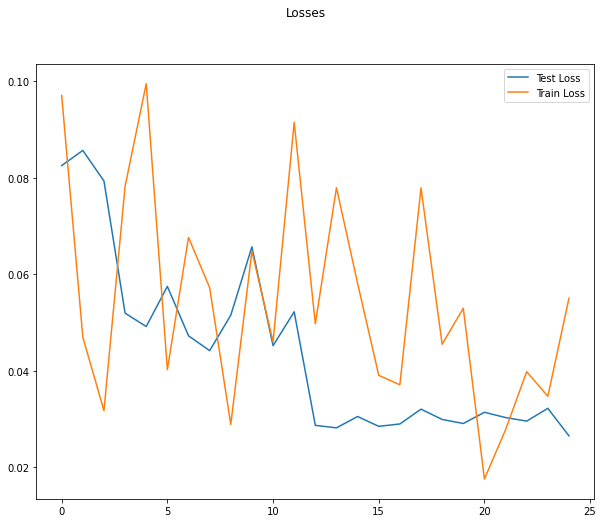

In [20]:
lst_plottingJobs = []
lst_plottingJobs.append(test_losses)
lst_plottingJobs.append(train_losses)

lst_plottingLegends = []
lst_plottingLegends.append("Test Loss")
lst_plottingLegends.append("Train Loss")

Plot_MultiGraph(lst_plottingJobs,lst_plottingLegends,"Losses")

In [11]:
def Plot_Misclassified_Images(model, device, test_loader, num_of_images = 25):
  plt.figure(figsize=(12,12))
  plt.suptitle('Misclassifications');
  num_images = 0
  #print(len(test_loader))
  for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      #print(data.shape)
      output = model(data)
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      pred_num = pred.cpu().numpy()
      labels = target.cpu().numpy()
      #print('gues',pred_num[0][0])
      #print('lab',labels[0])
      index = 0
      for label, predict in zip(labels, pred_num):
        if label != predict[0]:
          #print('actual:',label)
          #print('pred',predict[0])
          num_images += 1
          p = plt.subplot((num_of_images/5),5,num_images)
          p.imshow(data[index].cpu().numpy().squeeze(),cmap='gray_r')
          p.set_xticks(()); p.set_yticks(()) # remove ticks
          p.set_title(f'Pred: {predict[0]}, Actual: {label}');
        index +=1
        if num_images == num_of_images:
          break
      if num_images == num_of_images:
          break


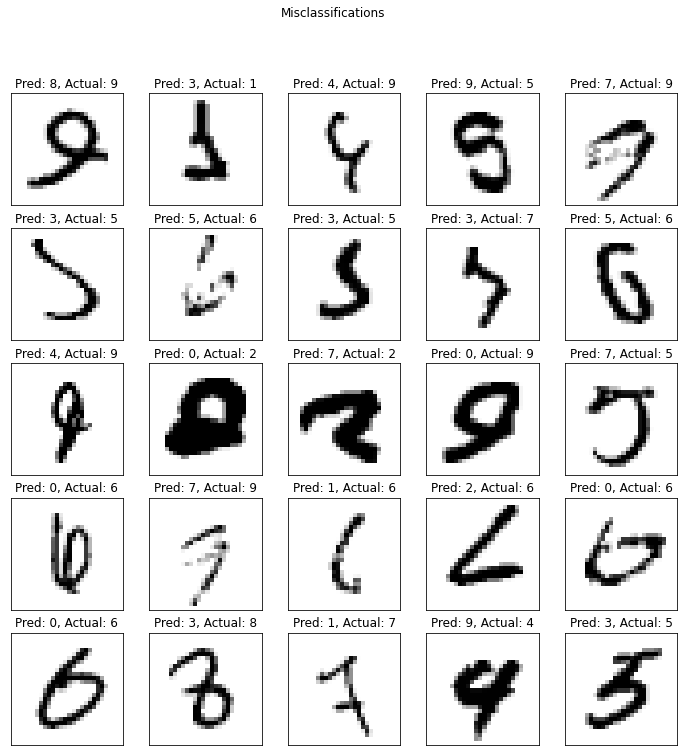

In [12]:
Plot_Misclassified_Images(model, device, test_loader, num_of_images = 25)